<a href="https://colab.research.google.com/github/Ericdaniel78/repo_prueba/blob/master/ModelosEscondidosMarkov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" />     en la nube

El siguiente "notebook" puede ser usado localmente o en la nube Colab de Google al aplicar Ctrl+Enter, o dar clic en el logo de play, en la siguiente celda (tarda de 2 a 3 minutos en instalarse Julia en la sesión de la nube) y posteriormente actualizar la página pulsando Ctrl+R, o F5.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.0" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia Distributions Plots"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "¡Exitosamente instalamos Julia en la nube!"
  echo "Actualice la página (Ctrl+R)."
fi

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


# Revisar la instalación
Para cersiorarnos de que la instalación de Julia en la nube haya sido correcta corremos el comando `versioninfo()` que imprime la versión de Julia que estamos utilizando y diversa información del sistema.

In [ ]:
versioninfo()

Julia Version 1.6.0
Commit f9720dc2eb (2021-03-24 12:55 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.00GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake-avx512)
Environment:
  JULIA_NUM_THREADS = 2


In [ ]:
# Función para calcular probabilidades forward (recursión hacia adelante)
function forward_probs_logsumexp(X::Array{Float64,1},p₀::Array{Float64,1},P::Array{Float64,2},μ_v::Array{Float64,1},σ_v::Array{Float64,1})
    D_v = [ Normal(μ_v[i],σ_v[i]) for i in 1:length(p₀)]
    n = length(X)
    d = length(p₀)
    log_forw = zeros(n,d)
    log_forw[1,:] = [ log( p₀[j] ) + log( pdf(D_v[j],X[1]) ) for j in 1:d]
    for i in 2:n
        a_tmp = zeros(d,d)
        b_tmp =  zeros(d)
        for j in 1:d
            a_tmp[j,:] = [ log_forw[i-1,k] + log(P[k,j]) for k in 1:d ]
            b_tmp[j] = maximum(a_tmp[j,:])
        end
        log_forw[i,:] = [ logpdf(D_v[j],X[i]) + b_tmp[j] + log( sum( exp.(a_tmp[j,:] .- b_tmp[j]) ) ) for j in 1:d ]
    end
    return log_forw
end

forward_probs_logsumexp (generic function with 1 method)

In [ ]:
# Función para calcular probabilidades backward (recursión hacia atras)
function backward_probs_logsumexp(X::Array{Float64,1},P::Array{Float64,2},μ_v::Array{Float64,1},σ_v::Array{Float64,1})
    D_v = [ Normal(μ_v[i],σ_v[i]) for i in 1:length(μ_v)]
    n = length(X)
    d = length(μ_v)
    log_backw = zeros(n,d)
    log_backw[end,:] = zeros(d)
    for i in reverse(1:(n-1))
        a_tmp = zeros(d,d)
        b_tmp =  zeros(d)
        for j in 1:d
            a_tmp[j,:] = [ log(P[j,k]) + log(pdf(D_v[k],X[i+1])) + log_backw[i+1,k]  for k in 1:d ]
            b_tmp[j] = maximum(a_tmp[j,:])
        end
        log_backw[i,:] = [ b_tmp[j] + log( sum( exp.(a_tmp[j,:] .- b_tmp[j]) ) ) for j in 1:d ]
    end
    return log_backw
end

backward_probs_logsumexp (generic function with 1 method)

In [ ]:
# Cálculo de probabilidades P[ Y_t = j | X ] para paso E)
function u_E_step_log(log_forw_probs::Array{Float64,2},log_backw_probs::Array{Float64,2})
    n,d = size(log_forw_probs)
    u_vec = zeros(n,d)
    for i in 1:n
        log_vec = log_forw_probs[i,:] .+ log_backw_probs[i,:]
        u_vec[i,:] = exp.( log_vec .- maximum(log_vec) .- log(sum(exp.(log_vec .- maximum(log_vec)))) )
    end
    return u_vec
end

u_E_step_log (generic function with 1 method)

In [ ]:
# Cálculo de probabilidades P[ Y_{t-1} = j, Y_t = i | X ] para paso E)
function v_E_step_log(X::Array{Float64,1},P::Array{Float64,2},μ_v::Array{Float64,1},σ_v::Array{Float64,1},log_forw_probs::Array{Float64,2},log_backw_probs::Array{Float64})
    D_v = [ Normal(μ_v[i],σ_v[i]) for i in 1:length(μ_v)]
    n,d = size(log_forw_probs)
    v_mat = zeros(n-1,d,d)
    for i in 1:(n-1)
        log_mat = [ log_forw_probs[i,j] + log(P[j,k]) + logpdf(D_v[k],X[i+1]) + log_backw_probs[i+1,k]  for j in 1:d, k in 1:d]
        v_mat[i,:,:] = exp.( log_mat .- maximum(log_mat) .- log(sum(exp.(log_mat .- maximum(log_mat)))) )
    end
    return v_mat
end

v_E_step_log (generic function with 1 method)

In [ ]:
# Paso M para obtener la matriz de transicón con las probabilidades P[ Y_t = j | X ] del paso E
function P_from_v(v::Array{Float64,3})
    P = sum( v, dims=1)[1,:,:]
    d = size(P,1)
    P_norm = zeros(d,d)
    for j in 1:d
        P_norm[j,:] = P[j,:] ./ sum(P[j,:])
    end
    return P_norm
end

P_from_v (generic function with 1 method)

In [ ]:
# Simulamos datos
μ = [3.0, 0.0] # vector de medias verdadero
σ = [1.0,  0.5] # vector de desviaciones estándar verdaderas
P = [ 0.7 0.3 ; 0.2 0.8 ] # matriz de transición verdadera
using Distributions;

In [ ]:
# Función para simular trayectoria observada y escondidad de tamaño n
function simHidden(n::Int64,P::Array{Float64,2},mu::Array{Float64,1},sig::Array{Float64,1})
Y = zeros(Int64, n) # Arreglo para cadena escondidad
X = zeros(Float64,n) # Arreglo para observaciones
Y[1] = 1 # Iniciamos en el estado 1
X[1] = rand(Normal(mu[1],sig[1])) # Emisión inicial
for i in 2:n
    # Transición dada por la matriz P
    if rand(Uniform()) < P[Y[i-1],Y[i-1]] 
        Y[i] = Y[i-1]
    else
        Y[i] = 3-Y[i-1]
    end
    # Emisión dada la transición
    X[i] = rand(Normal(mu[Y[i]],sig[Y[i]]))
end
return Y, X
end

simHidden (generic function with 1 method)

In [ ]:
n = 1000 # Número de observavciones
Y, X = simHidden(n,P,μ,σ)

([1, 1, 1, 1, 1, 1, 1, 1, 2, 2  …  2, 1, 1, 1, 2, 2, 1, 1, 2, 1], [3.810421663308767, 3.1976116417630744, 3.1715283964496774, 2.9099959836624936, 3.602434009178377, 3.6193672954298353, 3.59524661309061, 3.325183003218255, -0.3560170182655813, 0.6907990477695334  …  0.3574729856539492, 4.374370187972539, 3.2630438634340537, 2.8072829291293027, -0.08736113759461614, -0.12739866621666893, 2.4047222677009996, 3.2370828265046905, -0.6442156976187248, 4.039700935192828])

In [ ]:
function hiddenEM(m::Int64,X,Y)
# Inicialización del algoritmo EM
p₀_EM = zeros(m+1,2) # Arreglo para vector de probabilidades inciales
P_EM = zeros(m+1,2,2) # Arreglo para matrices de transición
μ_EM = zeros(m+1,2) # Arreglo para vector de medias de las emisiones Gaussianas
σ_EM = zeros(m+1,2) # Arreglo para vector de desviaciones estándar de las emisiones Gaussianas
σ_EM[1,:] = [ 1.0 for _ in 1:2] # Varianza incial 1
μ_EM[1,:] = [ X[rand(1:n)] for _ in 1:2] # Medias iniciales tomadas aleatoriamentes de los datos observados
p₀_EM[1,:] = [0.7,0.3] # Probabilidad inical para identificar que el estado 1 está más asociado al estado incial
P_EM[1,:,:] = [0.5 0.5 ; 0.5 0.5]; # Matriz de transición uniforme incial
for i in 2:(m+1)
    # Calculamos probabilidades forward temporales para la iteración del algoritmo EM
    tmp_log_forw = forward_probs_logsumexp(X,p₀_EM[i-1,:],P_EM[i-1,:,:],μ_EM[i-1,:],σ_EM[i-1,:])
    # Calculamos probabilidades backward temporales para la iteración del algoritmo EM
    tmp_log_backw = backward_probs_logsumexp(X,P_EM[i-1,:,:],μ_EM[i-1,:],σ_EM[i-1,:])
    # Paso E) calculamos probabilidades temporales para la iteración del algoritmo EM
    tmp_hat_u = u_E_step_log( tmp_log_forw, tmp_log_backw)
    tmp_hat_v = v_E_step_log( X,P_EM[i-1,:,:],μ_EM[i-1,:],σ_EM[i-1,:],tmp_log_forw, tmp_log_backw)
    # Paso M) probabilidades inciales
    p₀_EM[i,:] = tmp_hat_u[1,:]
    # Paso M) matriz de transición de probabilidad
    P_EM[i,:,:] = P_from_v(tmp_hat_v)
    for j in 1:2
        n_hat_u_i_j = sum( tmp_hat_u[:,j] )
        # Paso M) media de la emisión asociada al estado j
        μ_EM[i,j] = sum( tmp_hat_u[:,j] .* X  )/n_hat_u_i_j
        # Paso M) desviación estándar de la emisión asociada al estado j
        σ_EM[i,j] = sqrt( sum( tmp_hat_u[:,j] .*  ( X .- μ_EM[i,j] ).^2.0 )/n_hat_u_i_j )
    end
end
return p₀_EM, P_EM, μ_EM, σ_EM
end

hiddenEM (generic function with 1 method)

In [ ]:
m= 100 # Número de iteraciones del algoritmo
p₀_EM, P_EM, μ_EM, σ_EM = hiddenEM(m,X,Y)

([0.7 0.3; 0.8650775190710484 0.13492248092895165; … ; 1.0 0.0; 1.0 0.0], [0.5 0.5; 0.6018052843513848 0.5886311596840258; … ; 0.697975298247167 0.20767824123685996; 0.6979752982471664 0.20767824123685993]

[0.5 0.5; 0.3981947156486151 0.4113688403159741; … ; 0.30202470175283314 0.79232175876314; 0.3020247017528336 0.79232175876314], [-0.3767702649892483 -0.6115934845580603; 1.4875341224339282 0.8822202395949401; … ; 3.0195405593423867 0.019169263604093136; 3.0195405593423867 0.01916926360409306], [1.0 1.0; 1.6907789969732434 1.4941851238201067; … ; 0.9507470328806005 0.5053082532864669; 0.9507470328806008 0.5053082532864668])

In [ ]:
# Algoritmo de Viterbi para encontrar la trayectoria escondidad más probable 
function viterbi(X::Array{Float64,1},p₀::Array{Float64,1},P::Array{Float64,2},μ_v::Array{Float64,1},σ_v::Array{Float64,1})
    d= length(μ_v) # Número de estados escondidos
    D_v = [ Normal(μ_v[i],σ_v[i]) for i in 1:d ] # Vector de distribuciones para emisión por estado
    n = length(X) # Número de observaciones
    log_vit_mat = zeros(n,d)
    α_vec = zeros(Int64,n,d)
    log_vit_mat[1,:] = [ log(p₀[j]) + logpdf(D_v[j],X[1]) for j in 1:d ] 
    for i in 2:n
        # construcción de matriz para recursión
        max_tmp = [ findmax( logpdf(D_v[j],X[i]) .+ log_vit_mat[i-1,:] .+  log.(P[:,j]) ) for j in 1:d ]
        log_vit_mat[i,:] = [ max_tmp[j][1] for j in 1:d ]
        # maximización para recursión
        α_vec[i,:] = [ max_tmp[j][2] for j in 1:d ]
    end
    op_vit = zeros(Int64,n)
    op_vit[end] = findmax(log_vit_mat[end,:])[2]
    for i in reverse(1:(n-1))
        # recursión para algoritmo de Viterbi
        op_vit[i] = α_vec[i+1,op_vit[i+1]]
    end
    return op_vit
end

viterbi (generic function with 1 method)

In [ ]:
# Algoritmo de Viterbi con última iteración del algoritmo EM
v_EM = viterbi(X,p₀_EM[end,:],P_EM[end,:,:],μ_EM[end,:],σ_EM[end,:]);

In [ ]:
using Plots

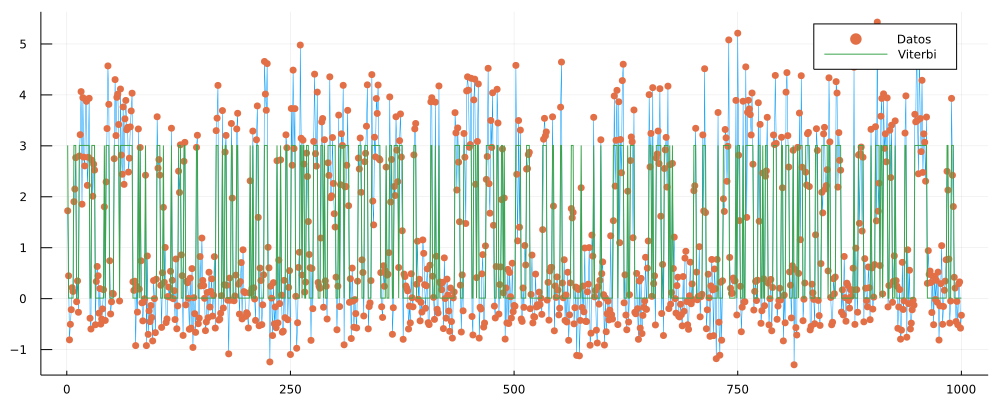

In [ ]:
p=plot(X, linewidth=0.5,label="")
scatter!(X, markerstrokewidth=0, label="Datos")
plot!(μ_EM[end,:][v_EM],label="Viterbi")
plot!(size=(1000,400))